In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import Corpus, download, TensorDecomposer

In [3]:
corpus = Corpus('convokit/tensor_decomposer/experiments/coarse-discourse-subset')

In [4]:
corpus.print_summary_stats()

Number of Speakers: 22156
Number of Utterances: 42603
Number of Conversations: 9357


Because each utterance has multiple annotation types and not necessarily a majority type, we randomly choose one type:

In [5]:
import random
from collections import defaultdict, Counter

In [6]:
for utt in corpus.iter_utterances():
    utt.meta['majority_type_'] = utt.meta['majority_type'] if utt.meta['majority_type'] is not None else random.choice(utt.meta['annotation-types'])

### An overview of common paths (controlling for length)

In [7]:
paths = [[utt.meta['majority_type_'] for utt in convo.get_chronological_utterance_list()] 
         for convo in corpus.iter_conversations()]

In [8]:
len_to_seqs = defaultdict(list)
for path in paths:
    len_to_seqs[len(path)].append('-'.join(path))

In [9]:
for length, seqs in len_to_seqs.items():
    print(length)
    print(sorted(list(Counter(seqs).items()), key=lambda v: v[1], reverse=True)[:10])
    print()

4
[('question-answer-question-answer', 368), ('question-answer-elaboration-elaboration', 202), ('question-answer-appreciation-elaboration', 131), ('question-question-answer-elaboration', 80), ('question-answer-appreciation-appreciation', 58), ('question-answer-agreement-elaboration', 55), ('question-answer-appreciation-answer', 52), ('question-answer-elaboration-appreciation', 50), ('question-answer-elaboration-agreement', 44), ('announcement-elaboration-elaboration-elaboration', 41)]

3
[('question-answer-elaboration', 414), ('question-answer-appreciation', 356), ('question-answer-agreement', 197), ('question-question-answer', 157), ('announcement-question-answer', 82), ('announcement-elaboration-elaboration', 67), ('question-answer-disagreement', 65), ('question-answer-question', 60), ('announcement-appreciation-appreciation', 40), ('question-answer-answer', 36)]

5
[('question-answer-question-answer-appreciation', 100), ('question-answer-elaboration-elaboration-elaboration', 81), ('

### A high-level transition matrix summary

In [10]:
types = set(utt.meta['majority_type_'] for utt in corpus.iter_utterances())

In [11]:
types

{'agreement',
 'announcement',
 'answer',
 'appreciation',
 'disagreement',
 'elaboration',
 'humor',
 'negativereaction',
 'other',
 'question'}

In [12]:
type_to_idx = {t: idx for idx, t in enumerate(sorted(types))}

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def compute_matrix(paths, idx, selector=lambda p: True):
    paths = [p for p in paths if selector(p)]
    if idx == 0:
        mat = np.zeros((len(types), 1))
        for path in paths:
            mat[type_to_idx[path[0]]] += 1
        mat /= np.sum(mat)
        ax = sns.heatmap(mat, yticklabels=list(sorted(types)), cmap="Blues", annot=True)
    else:
        paths = [p for p in paths if len(p) >= idx+1] # To find comment idx 1 to 2, I need threads of length 3
        mat = np.zeros((len(types), len(types)))
        for path in paths:
            mat[type_to_idx[path[idx-1]], type_to_idx[path[idx]]] += 1
#         mat /= np.sum(mat)
        mat = mat / (np.sum(mat, axis=1)+1)[:, None]
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(mat, yticklabels=[t+"_"+str(idx-1) for t in sorted(types)], 
                           xticklabels=[t+"_"+str(idx) for t in sorted(types)],
                           cmap="Blues", annot=True, ax=ax)
    ax.set_title('Transitions from comment idx {}'.format(idx-1))
    plt.show()

In [15]:
max_path = max(len(p) for p in paths)

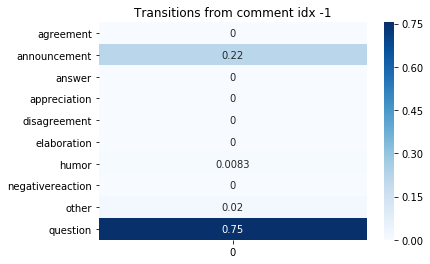

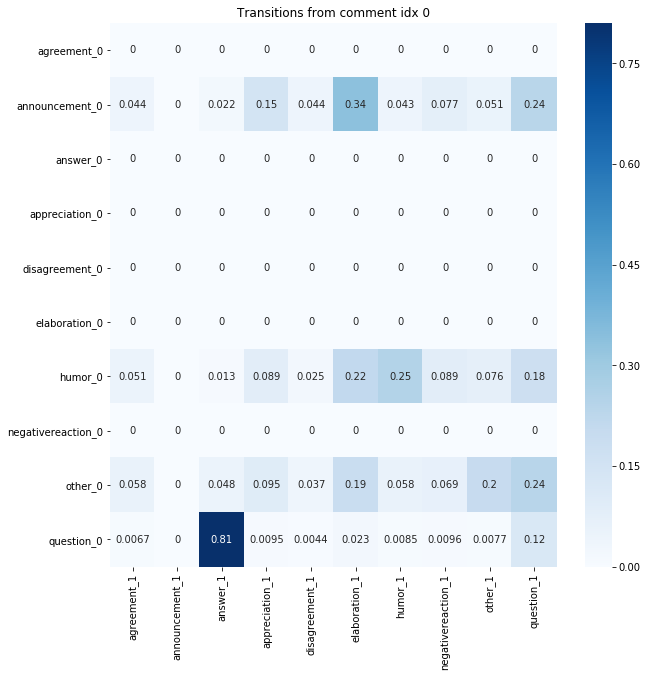

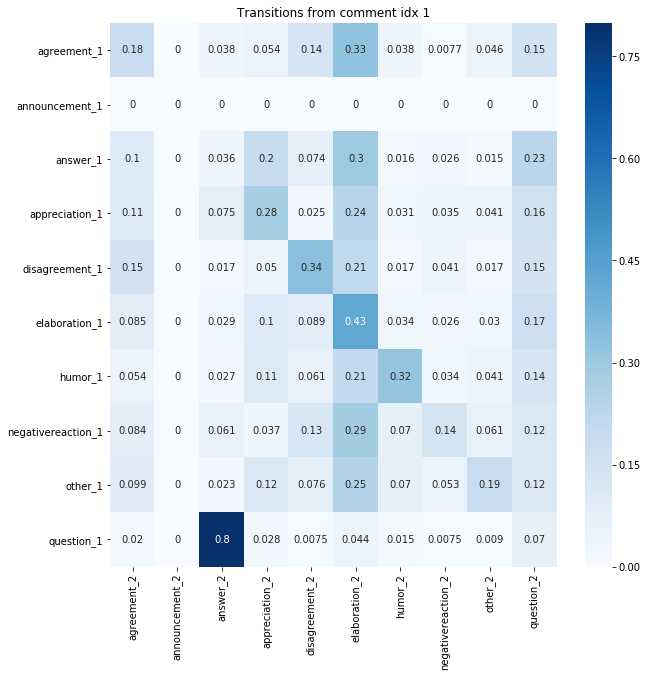

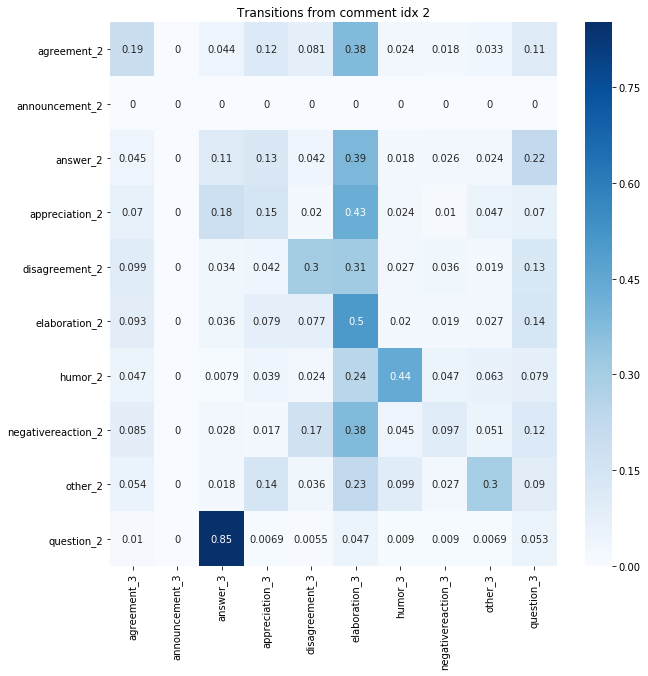

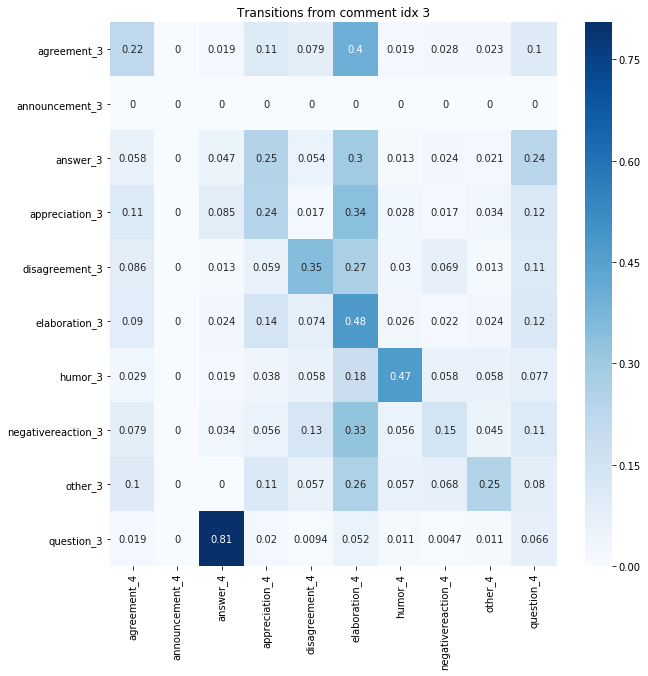

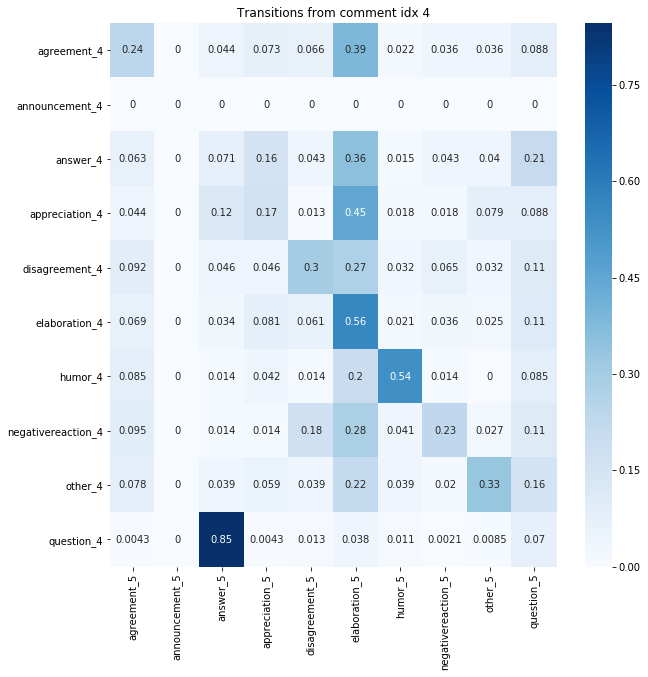

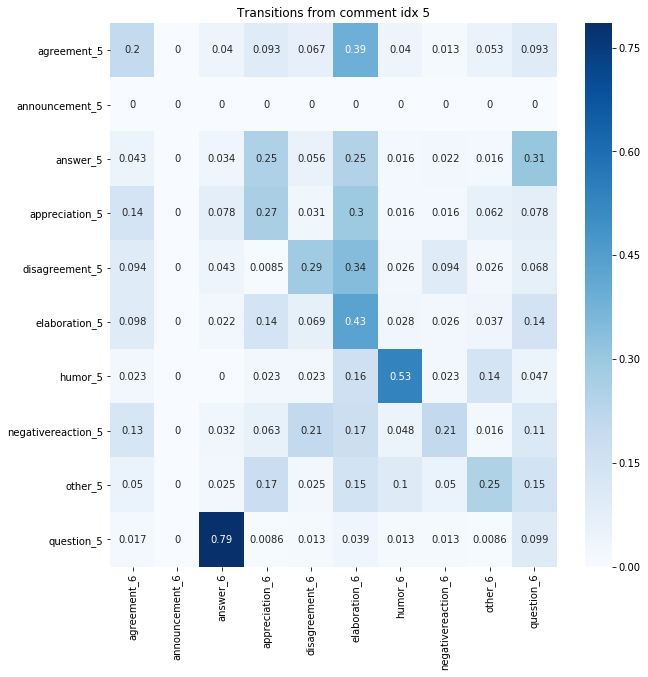

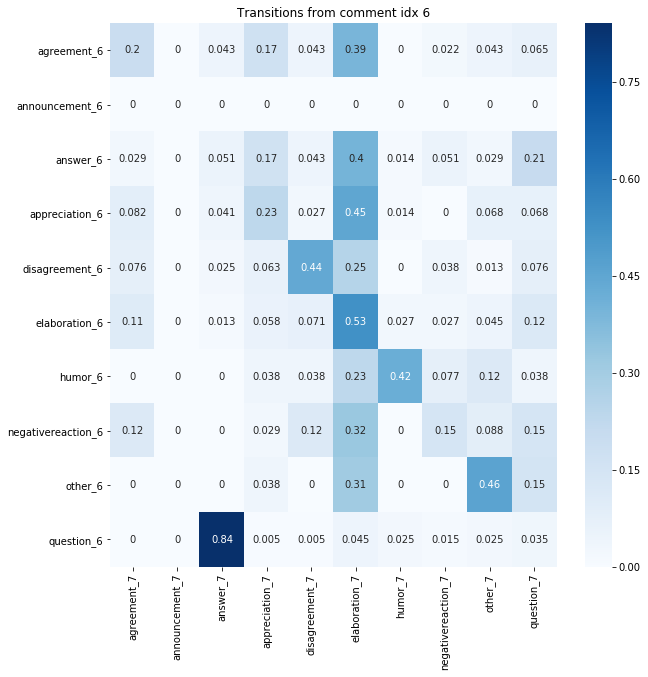

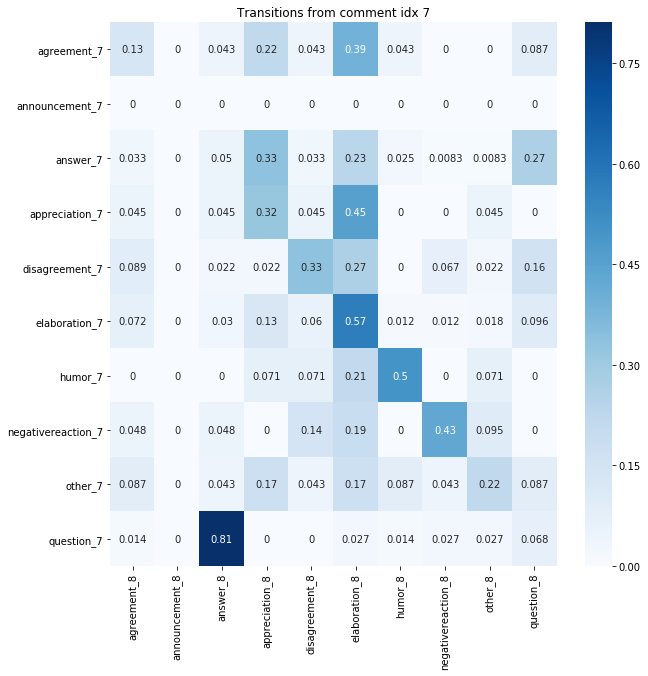

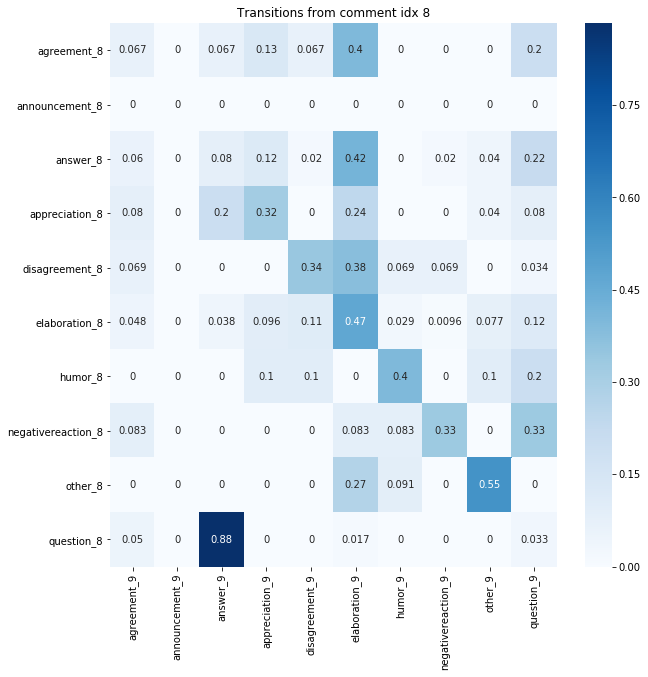

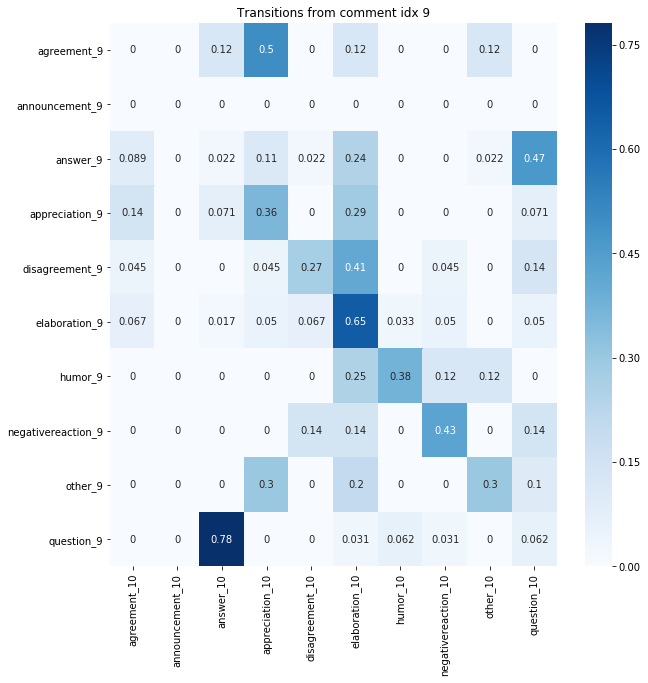

In [16]:
for idx in range(max_path):
    compute_matrix(paths, idx)

### What if we limit it to paths of length 8

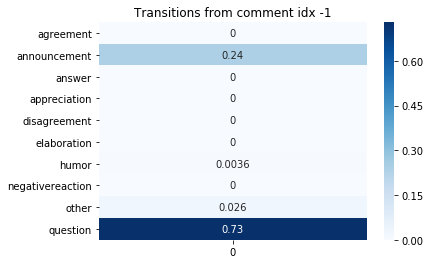

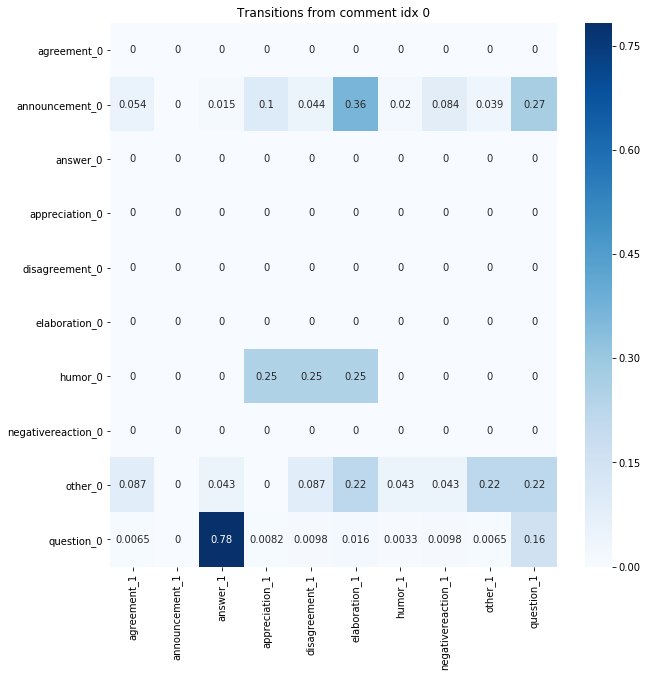

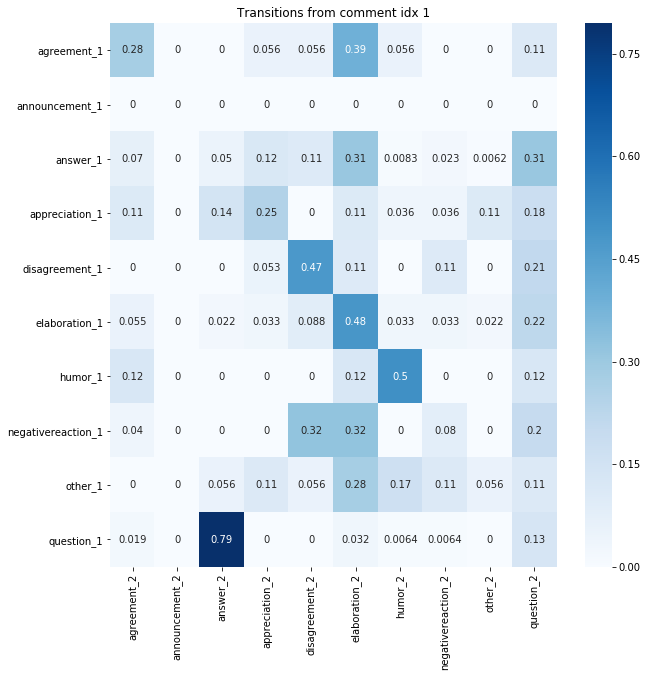

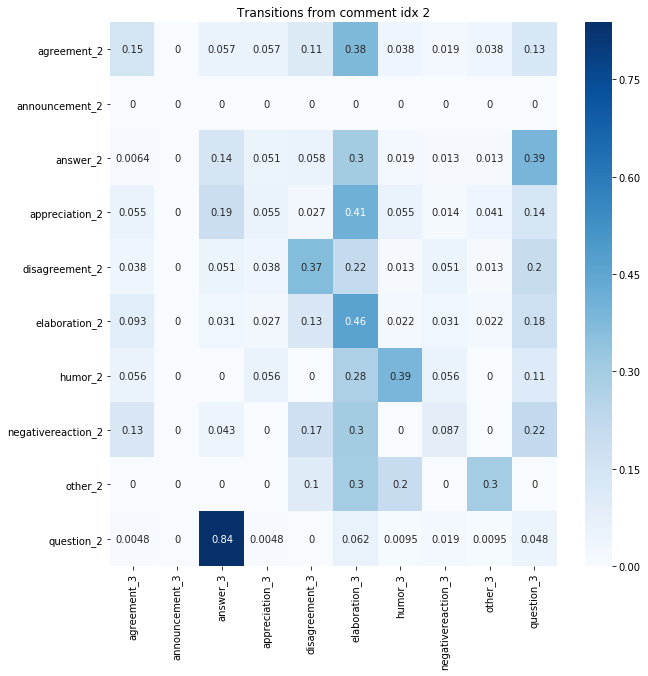

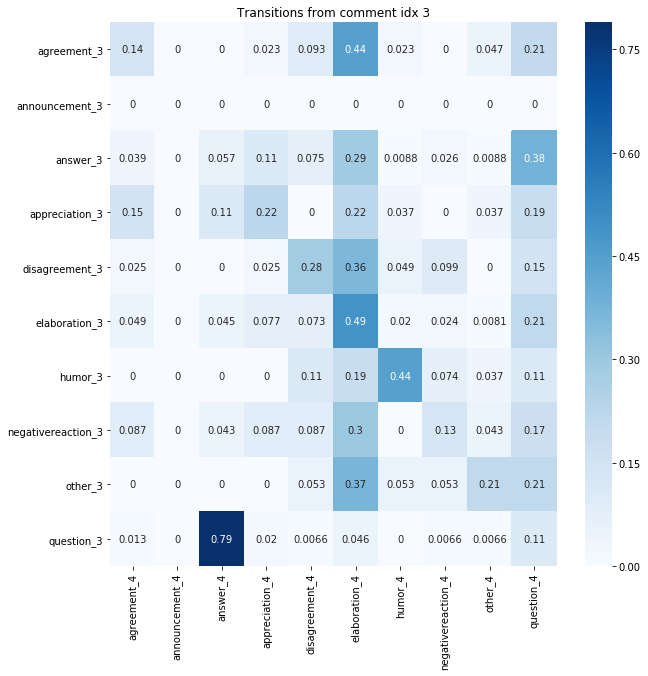

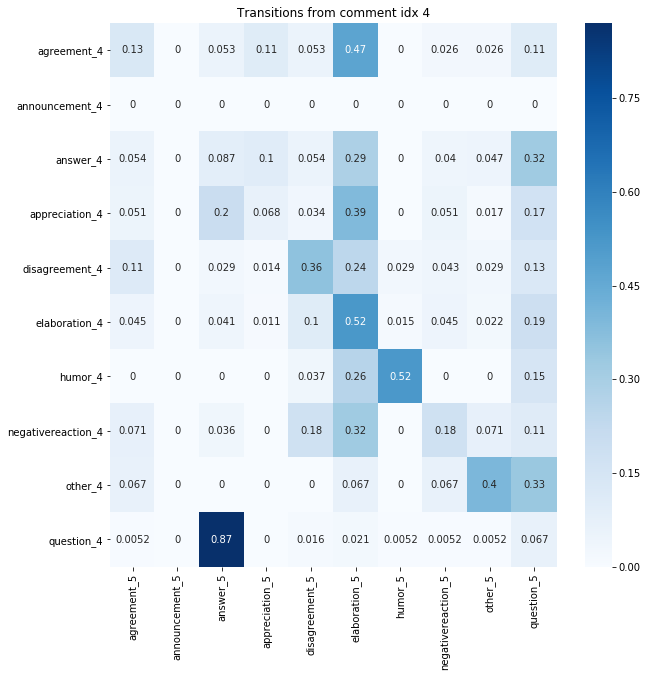

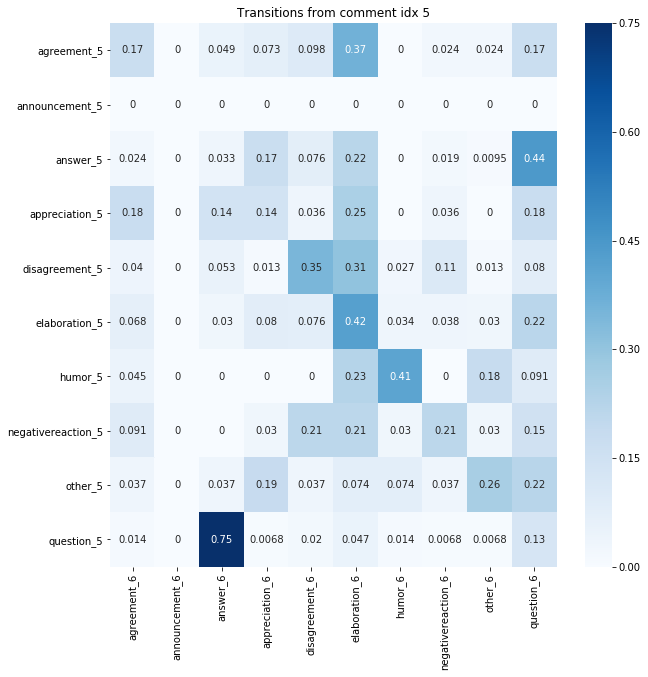

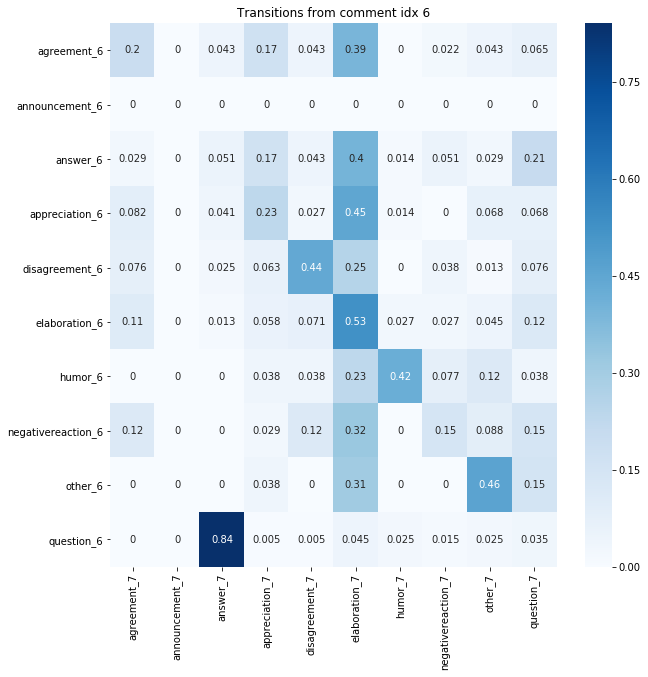

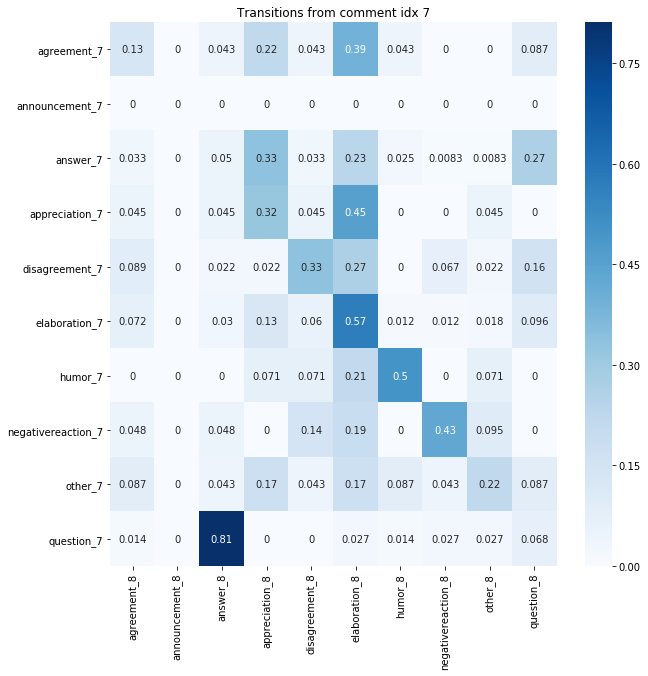

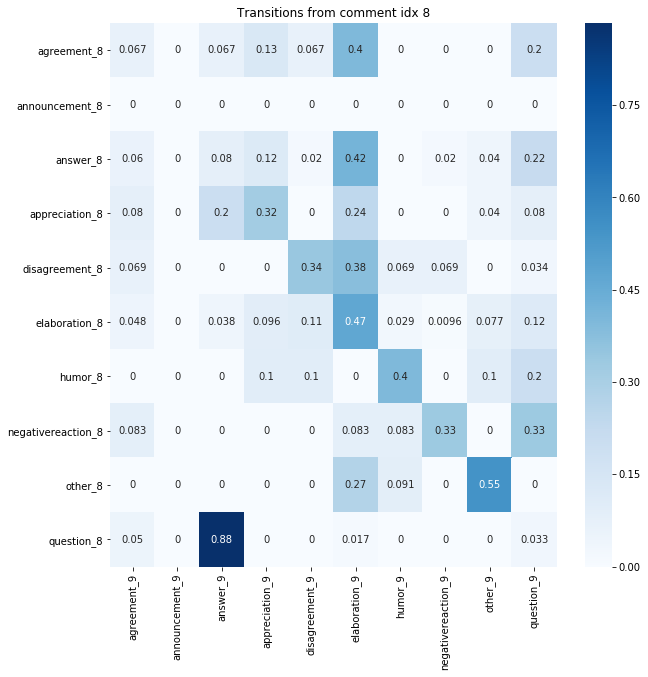

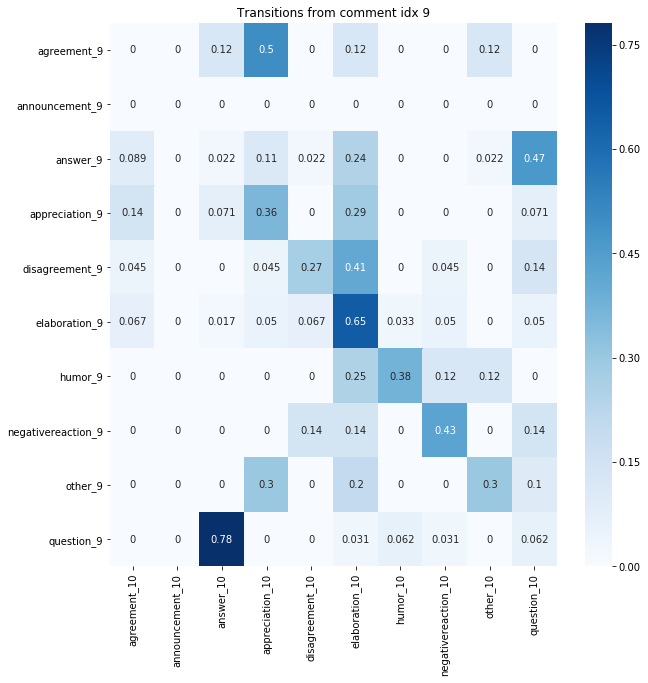

In [17]:
for idx in range(max_path):
    compute_matrix(paths, idx, selector=lambda p: len(p) >= 8)

In [18]:
td = TensorDecomposer(feature_set=['annot-dict-{}'.format(idx) for idx in range(1, 8+1)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=9)

In [19]:
td.fit(corpus, selector=lambda convo: convo.meta['longest_path'] >= 8)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8509910413039429, improvement inf.
NCP_BCD: iteration 2, objective 0.8199748812845583, improvement 0.031016160019384564.
NCP_BCD: iteration 3, objective 0.8012518008356705, improvement 0.01872308044888782.
NCP_BCD: iteration 4, objective 0.7886246031893049, improvement 0.012627197646365551.
NCP_BCD: iteration 5, objective 0.7788209439463941, improvement 0.009803659242910823.
NCP_BCD: iteration 6, objective 0.7700646976362262, improvement 0.008756246310167914.
NCP_BCD: iteration 7, objective 0.7622696836662493, improvement 0.007795013969976949.
NCP_BCD: iteration 8, objective 0.7553451829242506, improvement 0.006924500741998685.
NCP_BCD: iteration 9, objective 0.750131305091021, improvement 0.005213877833229574.
NCP_BCD: iteration 10, objective 0.74565086607342, improvement 0.004480439017600979.
NCP_BCD: iteration 11, objective 0.7412260867998379, improvement 0.004424779273582091.
NCP_BCD: iteration 12, o

Directory already exists. Exiting summarize()


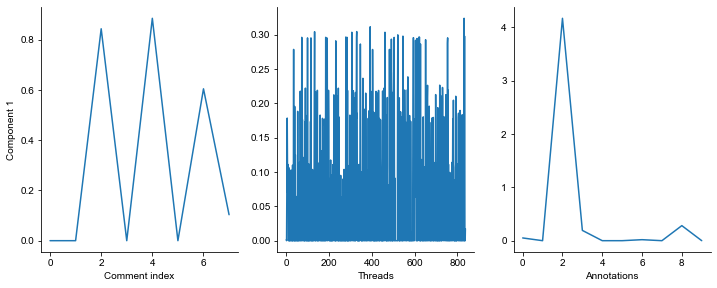

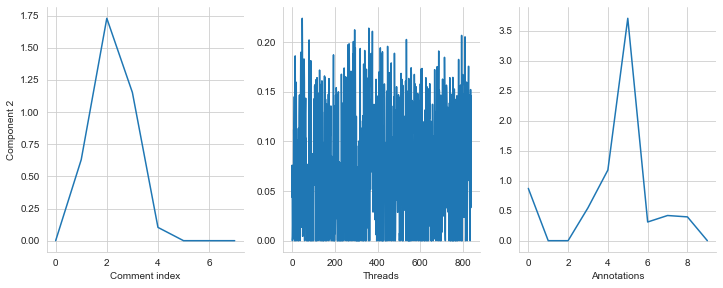

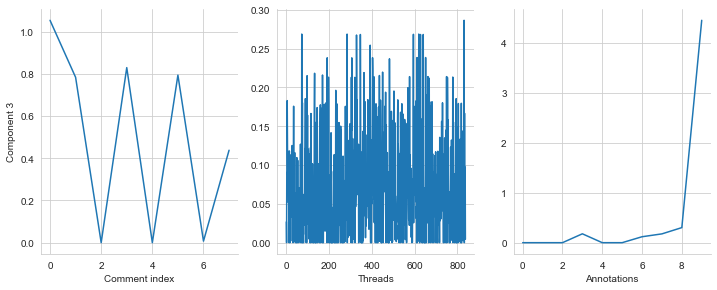

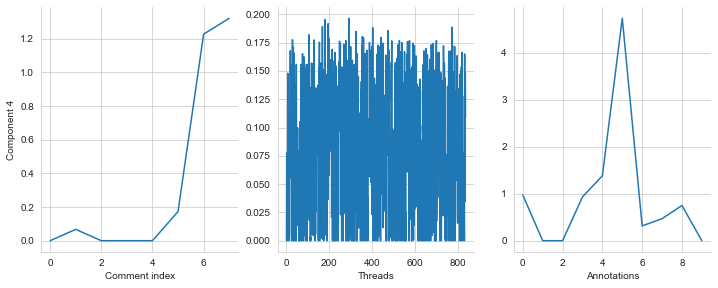

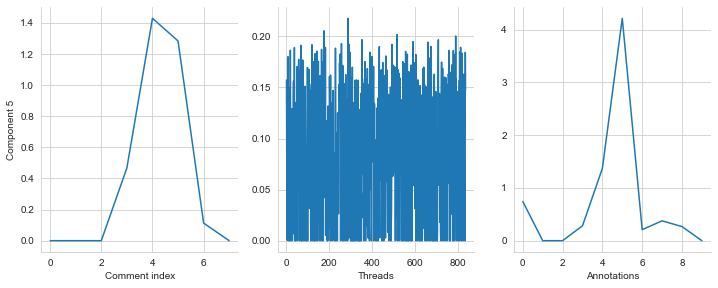

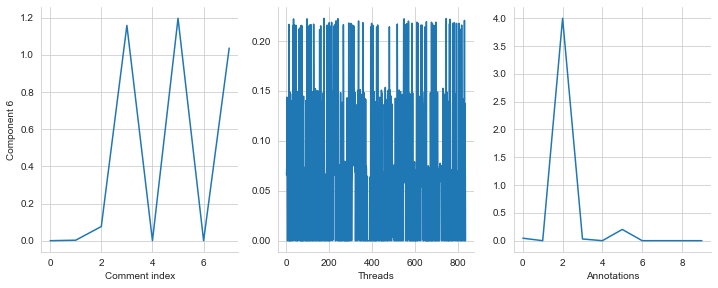

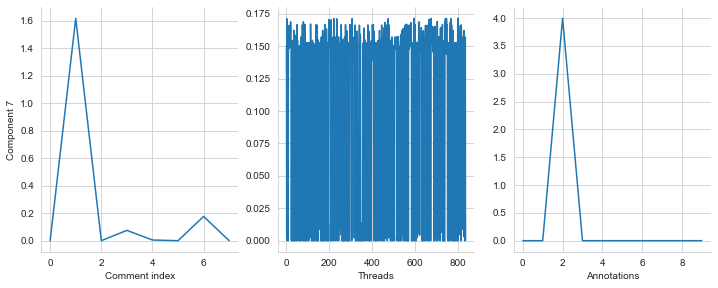

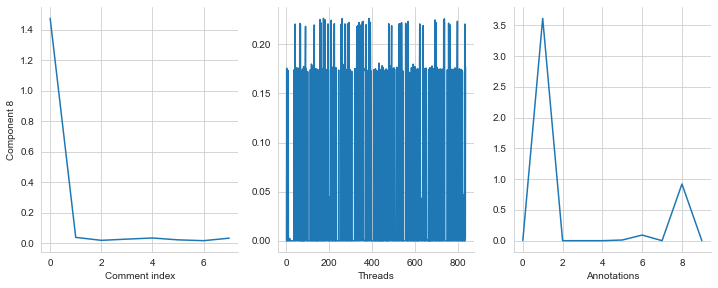

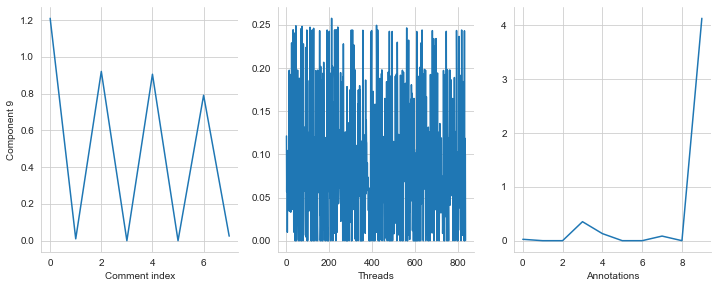

In [20]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

In [21]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2000, verbose=1)

In [23]:
df = corpus.get_conversations_dataframe(lambda c: c.meta['longest_path'] >= 8)
print(td.factors[1].shape)
projected_threads = tsne.fit_transform(td.factors[1])
print(projected_threads.shape)

xs = [x for (x, y) in projected_threads]
ys = [y for (x, y) in projected_threads]

df['x'] = xs
df['y'] = ys

(838, 9)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 838 samples in 0.000s...
[t-SNE] Computed neighbors for 838 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 838 / 838
[t-SNE] Mean sigma: 0.063518
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.208359
[t-SNE] KL divergence after 1000 iterations: 0.649209
(838, 2)


## TensorDecomposer with majority type

In [24]:
annotation_types = sorted(list(types))

In [25]:
for utt in corpus.iter_utterances():
    utt.meta['annot-dict'] = {k: 0 for k in annotation_types}
    for t in annotation_types:
        utt.meta[t] = 0
    utt.meta['annot-dict'][utt.meta['majority_type_']] = 1
    utt.meta[utt.meta['majority_type_']] = 1

In [26]:
for convo in corpus.iter_conversations():
    for idx, utt in enumerate(convo.get_chronological_utterance_list()):
        convo.meta['annot-dict-{}.format(idx+1)'] = utt.meta['annot-dict']

In [27]:
td = TensorDecomposer(feature_set=['annot-dict-{}'.format(idx) for idx in range(1, 8+1)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=9)

In [28]:
td.fit(corpus, selector=lambda convo: convo.meta['longest_path'] >= 8)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8543278181111773, improvement inf.
NCP_BCD: iteration 2, objective 0.8346816404327212, improvement 0.01964617767845611.
NCP_BCD: iteration 3, objective 0.8163731461956931, improvement 0.018308494237028072.
NCP_BCD: iteration 4, objective 0.7938104502747442, improvement 0.02256269592094895.
NCP_BCD: iteration 5, objective 0.7743765402012738, improvement 0.019433910073470395.
NCP_BCD: iteration 6, objective 0.7601606061469691, improvement 0.014215934054304658.
NCP_BCD: iteration 7, objective 0.7503093501619308, improvement 0.009851255985038332.
NCP_BCD: iteration 8, objective 0.7437865560187158, improvement 0.006522794143214994.
NCP_BCD: iteration 9, objective 0.7387897505716722, improvement 0.004996805447043617.
NCP_BCD: iteration 10, objective 0.7339727922516815, improvement 0.004816958319990627.
NCP_BCD: iteration 11, objective 0.7293471224722126, improvement 0.004625669779468988.
NCP_BCD: iteration 12,

In [34]:
for convo in corpus.iter_conversations():
    convo.meta['path'] = '-'.join([type_to_trunc[utt.meta['majority_type_']] for utt in convo.get_chronological_utterance_list()][:8])

In [35]:
df = corpus.get_conversations_dataframe(lambda c: c.meta['longest_path'] >= 8)

In [36]:
print(td.factors[1].shape)
projected_threads = tsne.fit_transform(td.factors[1])
print(projected_threads.shape)

xs = [x for (x, y) in projected_threads]
ys = [y for (x, y) in projected_threads]

df['x'] = xs
df['y'] = ys

(838, 9)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 838 samples in 0.000s...
[t-SNE] Computed neighbors for 838 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 838 / 838
[t-SNE] Mean sigma: 0.071467
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.078468
[t-SNE] KL divergence after 1000 iterations: 0.982952
(838, 2)


In [31]:
type_to_trunc = {
    'agreement': 'agmt',
    'announcement': 'anc',
    'answer': 'ans',
    'appreciation': 'appr',
    'disagreement': 'dsgmt',
    'elaboration': 'elab',
    'humor': 'hmr',
    'negativereaction': 'negR',
    'other': 'othr',
    'question': 'qn'
}

In [37]:
import plotly.express as px
fig = px.scatter(df, x='x', y='y', hover_data=['meta.path'])
fig.show()

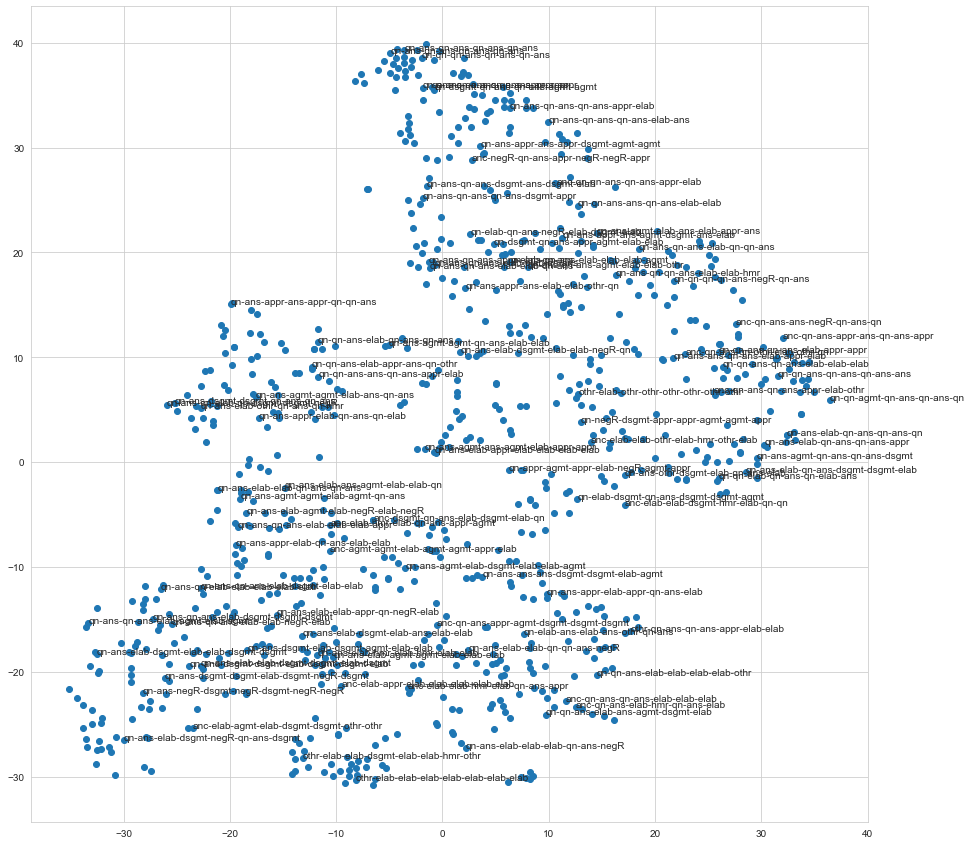

In [38]:
plt.figure(figsize=(15,15))
plt.scatter(df['x'].values, df['y'].values)
for i, convo_id in enumerate(df.index):
    if random.random() < 0.1:
        plt.annotate(corpus.get_conversation(convo_id).meta['path'], (df.iloc[i]['x'], df.iloc[i]['y']))
plt.show()

In [43]:
utt_df = corpus.get_utterances_dataframe()

In [46]:
from collections import Counter

In [60]:
utt_df[(utt_df['meta.post_depth'] == 7) & (utt_df['meta.disagreement'] == 1)]

(67, 23)

In [42]:
corpus.random_conversation().print_conversation_structure(lambda utt: str(utt.meta['post_depth']))

0
    1
        2
